# Data Analytics Group Project

## 1. Data Preparation

In [2]:
import numpy as np
import pandas as pd
import pylab as plt
from matplotlib import colors
from IPython.display import Image

In [3]:
df = pd.read_excel('two-phase flow correlation data.xlsx')

def is_real_and_finite(x):
    if not np.isreal(x):
        return False
    elif not np.isfinite(x):
        return False
    else:
        return True
    
all_data = df[df.columns[1:]].values
numeric_map = df[df.columns[1:]].applymap(is_real_and_finite)
real_rows = numeric_map.all(axis = 1).copy().values
X = np.array(all_data[real_rows, 1:], dtype = 'float')
y = np.array(all_data[real_rows, 0], dtype = 'float')
y = y.reshape(-1, 1)
x_names = [str(x) for x in df.columns[2:]]
y_name = df.columns[1]

print('X matrix dimensions: {}'.format(X.shape))
print('y matrix dimensions: {}'.format(y.shape))
#print(X)
#print(x_names)

X matrix dimensions: (8057, 7)
y matrix dimensions: (8057, 1)


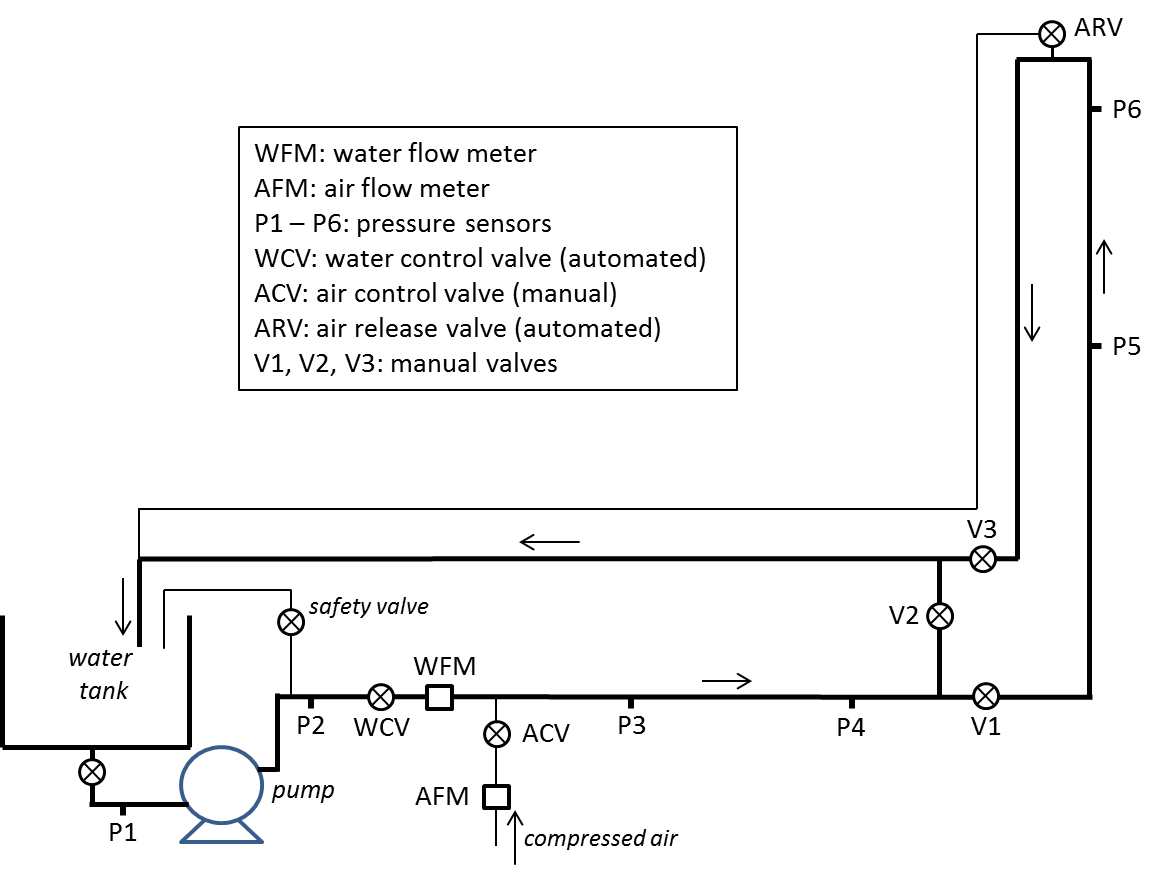

In [4]:
Image(filename='two-phase flow pressure drop.png')

Text(0.5, 0, 'P6 (kPa)')

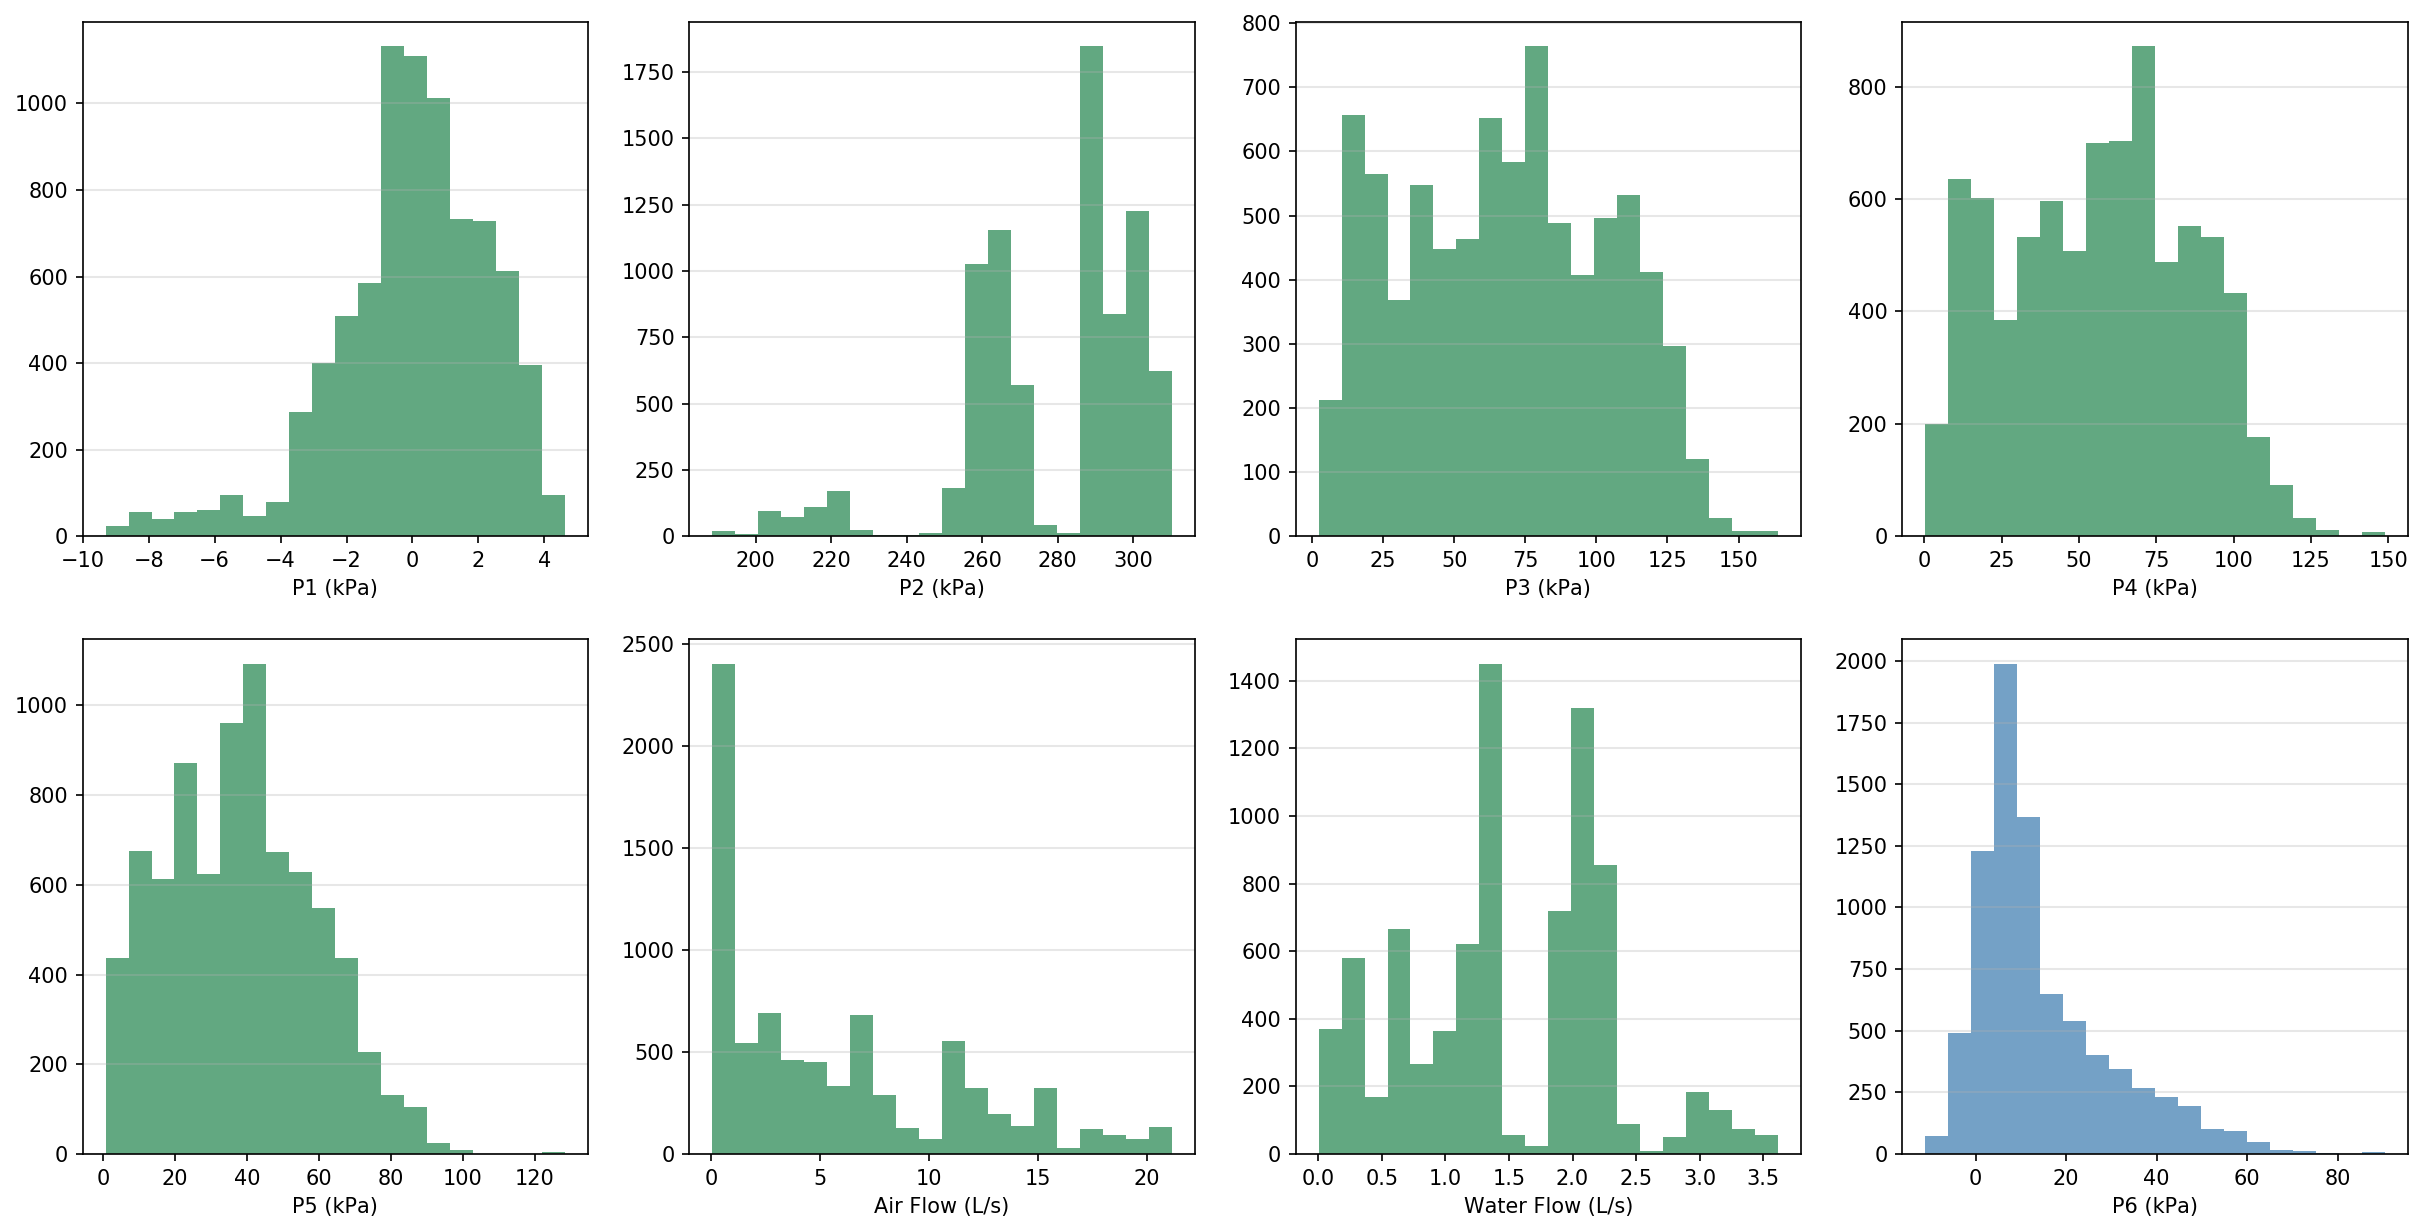

In [5]:
#distribution of each feature
fig, axes = plt.subplots(2, 4, figsize = (20, 10), dpi = 150)
for i in range(2):
    for j in range(4):
        feature = i*4+j
        if feature <= 6:
            axes[i,j].grid(axis='y', linestyle='-', linewidth=1, alpha=0.3)
            axes[i,j].hist(X[:,feature], bins=20, facecolor='seagreen', alpha=0.75)
            axes[i,j].set_xlabel(x_names[feature])
#distribution of target variable
axes[1,3].grid(axis='y', linestyle='-', linewidth=1, alpha=0.3)
axes[1,3].hist(y, bins=20, facecolor='steelblue', alpha=0.75)
axes[1,3].set_xlabel(y_name)

In [6]:
print('Data distributions:\n\n"normal": P1, P3, P4')
print('"random": P2, Air Flow, Water Flow')
print('"damped": P5, P6')

Data distributions:

"normal": P1, P3, P4
"random": P2, Air Flow, Water Flow
"damped": P5, P6
